# Обучить сиамскую сеть для верификации лиц на датасете LFW

# Библиотеки: [Python, Tensorflow]

## Libs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras import layers

## Load data

In [2]:
(train_ds, test_ds), ds_info = tfds.load(
    name='lfw',
    as_supervised=True, with_info=True, 
    split=['train[:90%]', 'train[90%:]']
)

## View data

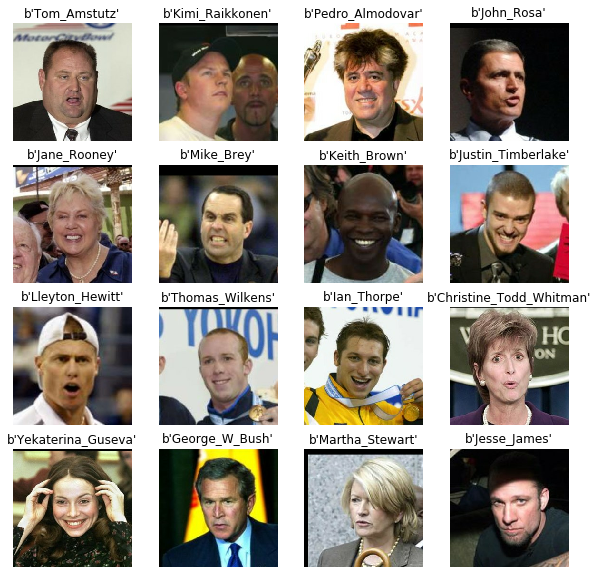

In [3]:
plt.figure(figsize=(10, 10))
for i, x in enumerate(train_ds.take(16)):
    plt.subplot(4, 4, i+1)
    plt.title(x[0].numpy())
    plt.imshow(x[1])
    plt.axis('off')

In [4]:
ex_lbl, ex_img = next(iter(train_ds.take(1)))
np.min(ex_img), np.max(ex_img), ex_img.shape

(0, 255, TensorShape([250, 250, 3]))

## Pipline data

Цвета фотографий для этой задачи не важны, переведем их в один канал. А так же попробуем уменьшить их разрешение.

In [5]:
BATCH_SIZE = 64
EPOCHS = 50
SIZE = 64

def prep_imgs(lbl, img):
    img = tf.cast(img, tf.float32) / 255
    img = tf.reduce_mean(img, 2)
    img = tf.reshape(img, (250, 250, 1))
    img = tf.image.resize(img, (SIZE, SIZE))
    return lbl, img

train_ds = train_ds.map(prep_imgs)
train_ds = train_ds.repeat(EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE)

test_ds = test_ds.map(prep_imgs)
test_ds = test_ds.batch(BATCH_SIZE)

test_ds

<BatchDataset shapes: ((None,), (None, 64, 64, 1)), types: (tf.string, tf.float32)>

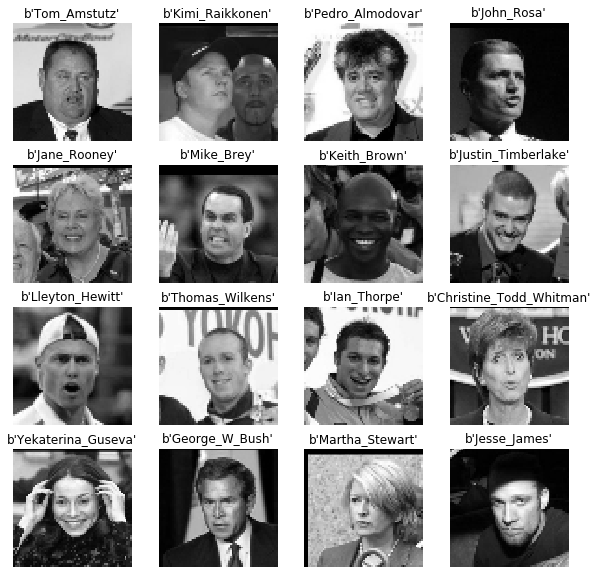

In [6]:
y, x = next(iter(train_ds.take(1)))

plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x[i, ..., 0], cmap='gray')
    plt.title(y[i].numpy())
    plt.axis('off')

## Model

Составим архитектуру таким образом, что бы сверточные слои и пулинги, уменьшили число пикселей фотографии в максимально возможное число юнитов для входа в полносвязный слой.

In [7]:
class Model(tf.keras.Model):
    def __init__(self, emb_size):
        super().__init__()
        self.conv1 = layers.Conv2D(32, (5, 5), padding='same', activation='relu')
        self.conv2 = layers.Conv2D(64, (5, 5), padding='same', activation='relu')
        self.conv3 = layers.Conv2D(128, (5, 5), padding='same', activation='relu')
        self.conv4 = layers.Conv2D(256, (5, 5), padding='same', activation='relu')
        
        self.conv5 = layers.Conv2D(512, (5, 5), padding='same', activation='relu')
        self.conv6 = layers.Conv2D(1024, (5, 5), padding='same', activation='relu')
        
        self.pool = layers.MaxPool2D((2, 2), (2, 2))
        self.flat = layers.Flatten()
        self.drop = layers.Dropout(0.5)
        
        self.dense1 = layers.Dense(1024, activation='relu')
        self.dense2 = layers.Dense(emb_size, activation=None)
        
    def call(self, inp):
        out = self.conv1(inp)
        out = self.pool(out)
        out = self.conv2(out)
        out = self.pool(out)
        out = self.conv3(out)
        out = self.pool(out)
        out = self.conv4(out)
        out = self.pool(out)
        
        out = self.conv5(out)
        out = self.pool(out)
        out = self.conv6(out)
        out = self.pool(out)
        
        out = self.flat(out)
        
        out = self.dense1(out)
        out = self.drop(out)
        out = self.dense2(out)
        
        return out

## Castom loss

In [8]:
MARGIN = 10.0

def contastive_loss(embs, labels):
    bs = embs.shape[0]
    
    embs1 = embs[:bs//2, :]
    embs2 = embs[bs//2:, :]
    
    labels1 = labels[:bs//2]
    labels2 = labels[bs//2:]

    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
    d = tf.sqrt(d2)
    z = tf.cast(labels1 == labels2, tf.float32)
    
    return tf.reduce_mean(z * d2 + (1 - z) * tf.maximum(0, MARGIN - d)**2)

## Trining

In [9]:
EMB_SIZE = 64
LEARNING_RATE = 0.001

model = Model(EMB_SIZE)
optimizer = tf.keras.optimizers.Nadam(LEARNING_RATE)

In [10]:
%%time

lbls_v, imgs_v = next(iter(test_ds))

train_loss = []
val_loss = []

for i, (lbls, imgs) in enumerate(train_ds):
    with tf.GradientTape() as tape:
        embs = model(imgs)
        loss_value = contastive_loss(embs, lbls)
        
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))
    
    if i % 500 == 0:
        embs_v = model(imgs_v)
        loss_value_v = contastive_loss(embs_v, lbls_v)
        
        train_loss.append(loss_value)
        val_loss.append(loss_value_v)
        
        print(f'[{i}]\tLoss: {loss_value.numpy():.4f}\t| Val loss: {loss_value_v.numpy():.4f}')

[0]	Loss: 99.7612	| Val loss: 80.7592
[500]	Loss: 1.4228	| Val loss: 0.0523
[1000]	Loss: 1.3101	| Val loss: 0.0000
[1500]	Loss: 0.0000	| Val loss: 0.0617
[2000]	Loss: 0.4858	| Val loss: 0.0220
[2500]	Loss: 4.3261	| Val loss: 1.8954
[3000]	Loss: 0.0000	| Val loss: 0.5220
[3500]	Loss: 1.0645	| Val loss: 1.5795
[4000]	Loss: 2.1325	| Val loss: 1.7201
[4500]	Loss: 2.9490	| Val loss: 1.1933
[5000]	Loss: 1.5101	| Val loss: 0.0000
[5500]	Loss: 0.0000	| Val loss: 0.2771
[6000]	Loss: 0.0191	| Val loss: 1.0811
[6500]	Loss: 1.8224	| Val loss: 1.3952
[7000]	Loss: 0.2801	| Val loss: 0.0353
[7500]	Loss: 0.0000	| Val loss: 0.7625
[8000]	Loss: 0.0000	| Val loss: 0.0349
[8500]	Loss: 0.1042	| Val loss: 0.0000
[9000]	Loss: 0.4063	| Val loss: 0.1663
Wall time: 23min 20s


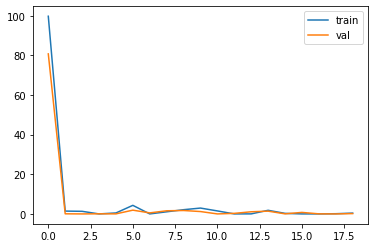

In [11]:
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.legend()

## View test

In [12]:
%%time
test_imgs = []
test_lbls = []
test_embs = []

for lbls, imgs in test_ds:
    test_imgs.append(imgs)
    test_lbls.append(lbls)
    test_embs.append(model(imgs))

test_imgs = tf.concat(test_imgs, 0).numpy()
test_lbls = tf.concat(test_lbls, 0).numpy()
test_embs = tf.concat(test_embs, 0).numpy()

print(f'imgs: {test_imgs.shape}\nlbls: {test_lbls.shape}\nembs: {test_embs.shape}')

imgs: (1323, 64, 64, 1)
lbls: (1323,)
embs: (1323, 64)
Wall time: 1.87 s


In [13]:
test_lbl_count = {}
for i in test_lbls:
    if i in test_lbl_count:
        test_lbl_count[i] += 1
    else:
        test_lbl_count[i] = 1
        
test_lbls.size, len(test_lbl_count)

(1323, 962)

In [14]:
test_lbl_count = list(test_lbl_count.items())
test_lbl_count = sorted(test_lbl_count, key = lambda x: x[1], reverse=True)
test_lbl_top10 = test_lbl_count[:10]
test_lbl_top10

[(b'George_W_Bush', 45),
 (b'Colin_Powell', 25),
 (b'Donald_Rumsfeld', 17),
 (b'Tony_Blair', 15),
 (b'Gerhard_Schroeder', 11),
 (b'Jacques_Chirac', 9),
 (b'Ariel_Sharon', 8),
 (b'Junichiro_Koizumi', 7),
 (b'Vladimir_Putin', 6),
 (b'Luiz_Inacio_Lula_da_Silva', 6)]

In [15]:
%%time
test_imgs_flatt = test_imgs.reshape(-1, SIZE*SIZE)
test_imgs_flatt = test_imgs_flatt[:, :64]

test_imgs_2d = TSNE(n_components=2).fit_transform(test_imgs_flatt)
test_embs_2d = TSNE(n_components=2).fit_transform(test_embs)

test_imgs_2d.shape, test_embs_2d.shape

Wall time: 18.8 s


((1323, 2), (1323, 2))

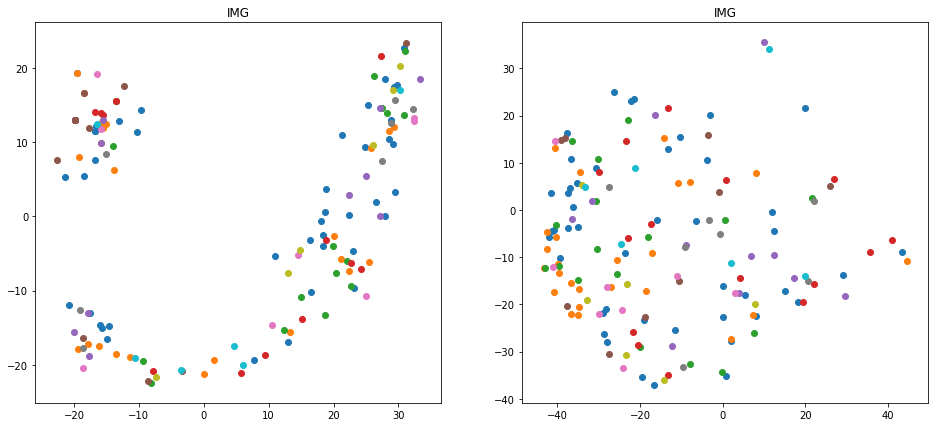

In [16]:
def scattering(xy, name):
    for i in test_lbl_top10:
        plt.scatter(
            xy[np.where(test_lbls == i[0])[0], 0],
            xy[np.where(test_lbls == i[0])[0], 1],
            label=i[0]
        )
#     plt.legend()
    plt.title('IMG')

plt.figure(figsize=(16, 7))

plt.subplot(1, 2, 1)
scattering(xy=test_imgs_2d, name='IMG')

plt.subplot(1, 2, 2)
scattering(xy=test_embs_2d, name='EMB')

Кластеризация фотографий не наблюдается

## Check result

In [17]:
np.where(test_lbls == b'George_W_Bush')[0]

array([  38,   53,   94,  126,  153,  155,  191,  198,  210,  273,  276,
        312,  359,  465,  466,  474,  480,  502,  536,  567,  594,  604,
        635,  643,  666,  681,  717,  790,  859,  876,  889, 1007, 1019,
       1036, 1061, 1068, 1072, 1092, 1129, 1134, 1178, 1193, 1197, 1259,
       1302], dtype=int64)

In [18]:
np.where(test_lbls == b'Colin_Powell')[0]

array([  11,   19,   98,  108,  148,  184,  246,  264,  267,  335,  373,
        453,  457,  533,  555,  605,  719,  799,  813,  870,  888, 1042,
       1238, 1252, 1298], dtype=int64)

(-0.5, 63.5, 63.5, -0.5)

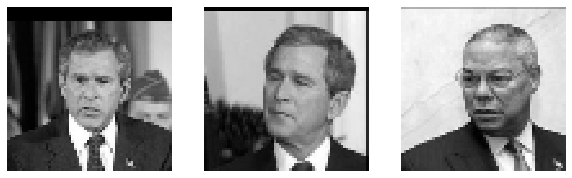

In [19]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(test_imgs[38, ..., 0], cmap='gray')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(test_imgs[53, ..., 0], cmap='gray')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(test_imgs[11, ..., 0], cmap='gray')
plt.axis('off')

In [20]:
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5

gwb38 = test_embs[38]
gwb53 = test_embs[53]
cp11 = test_embs[11]

print(f'gwb38 <-> gwb53: \t{diff(gwb38, gwb53)}')
print(f'gwb38 <-> cp11: \t{diff(gwb38, cp11)}')
print(f'gwb53 <-> cp11: \t{diff(gwb53, cp11)}')

gwb38 <-> gwb53: 	30.719418585361545
gwb38 <-> cp11: 	30.258756520904925
gwb53 <-> cp11: 	10.637604541018328


## Resume

Результаты не очень хорошие - машинка путает людей на фотографии, причина не понятна